In [1]:
import pandas as pd
import numpy as np
import torch
from typing import List, Tuple, Sequence
SEED=20

In [2]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# backup location
#!curl -o ml-latest-small.zip http://www.dcs.gla.ac.uk/~craigm/recsysHM/ml-latest-small.zip
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  955k    0  1183    0     0   3853      0  0:04:13 --:--:--  0:04:13  3840
 44  955k   44  428k    0     0   327k      0  0:00:02  0:00:01  0:00:01  327k
100  955k  100  955k    0     0   551k      0  0:00:01  0:00:01 --:--:--  551k
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

# treat userId as strings, and similarly as movies. This will prevent confusion later on.
ratings_df['userId'] =  "u" + ratings_df['userId'].astype(str)
ratings_df['movieId'] = "m" + ratings_df['movieId'].astype(str)
movies_df['movieId'] = "m" +  movies_df['movieId'].astype(str)

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931


In [5]:
ratings_df[ratings_df['userId']=='u1']

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931
...,...,...,...,...
227,u1,m3744,4.0,964980694
228,u1,m3793,5.0,964981855
229,u1,m3809,4.0,964981220
230,u1,m4006,4.0,964982903


In [6]:
len(movies_df)

9742

In [7]:
movies_df.head()

,movieId,title,genres
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m2,Jumanji (1995),Adventure|Children|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m5,Father of the Bride Part II (1995),Comedy


# User-based CF

In [8]:
r_df_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,...,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
r_df_matrix.iloc[0]

movieId
m1         4.0
m10        0.0
m100       0.0
m100044    0.0
m100068    0.0
          ... 
m99853     0.0
m999       0.0
m99910     0.0
m99917     0.0
m99992     0.0
Name: u1, Length: 9724, dtype: float64

In [10]:
r_df_matrix.index

Index(['u1', 'u10', 'u100', 'u101', 'u102', 'u103', 'u104', 'u105', 'u106',
       'u107',
       ...
       'u90', 'u91', 'u92', 'u93', 'u94', 'u95', 'u96', 'u97', 'u98', 'u99'],
      dtype='object', name='userId', length=610)

In [11]:
r_df_matrix.loc['u1']

movieId
m1         4.0
m10        0.0
m100       0.0
m100044    0.0
m100068    0.0
          ... 
m99853     0.0
m999       0.0
m99910     0.0
m99917     0.0
m99992     0.0
Name: u1, Length: 9724, dtype: float64

In [12]:
# User-based CF heavily relies upon Cosine similarity.
def cos_sim(a, b):
  from numpy.linalg import norm
  from numpy import dot
  return dot(a, b)/(norm(a)*norm(b))

print('Cosine similarity between userId=1 and itself is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u1'].values))

print('Cosine similarity between userId=1 and userId=607 is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u607'].values))

Cosine similarity between userId=1 and itself is:
1.0
Cosine similarity between userId=1 and userId=607 is:
0.2693892401115333


## 1. Get the most similar users.

In [13]:
from scipy.stats import rankdata
#identify the userIds of the k most similar users to the specified
#userId, and their corresponding cosine similarities.
def get_most_similar_users(userId : str, k : int = 10) -> Tuple[Sequence[str], Sequence[float]]:

  # Get index of all user 
  all_user = r_df_matrix.index
  list_usr,list_cos = list(),list()
  # Compute cosine similarity between input user and other users except itself then save in list
  for usr in all_user:
    # Exclude user itself
    if usr != userId:
      list_usr.append(usr)
      list_cos.append(cos_sim(r_df_matrix.loc[userId].values, r_df_matrix.loc[usr].values))

  # Change list to array and get only index that not include zero
  array_usr = np.asarray(list_usr)
  array_cos = np.asarray(list_cos)
  usr_no_zero = array_usr[np.nonzero(array_cos)]
  cos_no_zero = array_cos[np.nonzero(array_cos)]

  # Ranking by multiply -1 to cosine value before using rankdata to get higher number be the first rank
  ranking = rankdata([-1 * i for i in cos_no_zero])

  topk_userids = [] # a list/numpy array of k userIds of top-k users
  topk_cosines = []  # a list/numpy array of k cosine similarity values

  # Find userid and it cosine value in k rank then save in list
  for i in range(1,k+1):
    topk_userids.append(usr_no_zero[np.where(ranking == i)][0]) 
    topk_cosines.append(cos_no_zero[np.where(ranking == i)][0])

  return (topk_userids, topk_cosines)

print(get_most_similar_users(userId='u3', k=1))

(['u313'], [0.07818732282993371])


You can now answer the questions corresponding to Task 1 in the quiz.

In [14]:
print(get_most_similar_users(userId='u10', k=1))

(['u159'], [0.28826463078187997])


In [15]:
print(get_most_similar_users(userId='u500', k=2))

(['u453', 'u45'], [0.27983214052930266, 0.26236874974336444])


## 2. Predict ratings via user-based CF.

In [16]:
def predict_rating(userId : str, movieId : str) -> float:

  # Get list of most similar user for 10 nearest neighbours
  sim_usr = get_most_similar_users(userId=userId, k=10)
  sim_rating = 0

  # Get movie rating value from list of most similar user and compute overall rating
  for i in range(0,len(sim_usr[0])):
    rating_val = r_df_matrix.loc[sim_usr[0][i]][movieId]
    sim_rating += sim_usr[1][i] * rating_val

  predicted = sim_rating / np.sum(sim_usr[1])  # predicted rating value
  return predicted

print("Predicted rating:", predict_rating(userId='u1', movieId='m1'))

print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Predicted rating: 2.3363751766665386
Actual rating: 4.0


## 3. Predict ratings via user-based CF with Mean-center normalisation.

Users usually rate differently: (1) some rate high, while others low. (2) Some use more of the scale than others. However, the user-based CF implemented above ignores these differences. To this end, apply normalisation to compensate.

In [17]:
def mean_rating(userId : str) -> float:

  # Compute average rating by get all user ratings that is not zero then find mean
  mean_rating = np.mean(r_df_matrix.loc[userId][r_df_matrix.loc[userId] > 0]) # mean-centering value
  return mean_rating

print("Mean rating of user u5:", mean_rating('u5') )

def predict_rating_MC(userId : str, movieId : str) -> float:

  # Get list of most similar user for 10 nearest neighbours and average rating of input user
  sim_usr = get_most_similar_users(userId=userId, k=10)

  user_mean_rating = mean_rating(userId)
  sim_rating = 0

  # Get movie rating value from list of most similar user and find their average rating then compute overall rating
  for i in range(0,len(sim_usr[0])):
    rating_val = r_df_matrix.loc[sim_usr[0][i]][movieId]
    avg_rating = mean_rating(sim_usr[0][i])
    sim_rating += sim_usr[1][i] * ( rating_val - avg_rating )
  predicted = user_mean_rating + ( sim_rating / np.sum(sim_usr[1]) ) # predicted rating value with mean-centering
  return predicted

print("Predicted rating:", predict_rating_MC('u1', 'm1'))
print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Mean rating of user u5: 3.6363636363636362
Predicted rating: 3.127985053034213
Actual rating: 4.0


### Explicit Matrix Factorisation using Spotlight

the Spotlight library -  https://github.com/maciejkula/spotlight - and  documentation at https://maciejkula.github.io/spotlight/

In [18]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight

Now we can get onto some real recommendation work. Spotlight has a handy [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object, which encapsulates the basics of a recommendation dataset.

In fact, there are handy loaders for a few standard datasets including MovieLens, but let's make our own, so that we can match back to the dataframe.

Interactions need numbers as userids and itemids. Unfortunately, our MovieLens uses numbers, but these aren't consecutive (i.e. we have missing movieIds values). They are also strings (i.e. movieIds start with "m" and userIds start with "u").

Hence, for both movies and users, we will use [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to convert the MovieLens strings down to consecutive integers for use in Spotlight, in the `uid_map` and `iid_map` objects. We'll keep the reverse mapping around too, in case we want to lookup the actual movieId given the uid recorded by Spotlight (etc).

In [19]:
from collections import defaultdict
from itertools import count

#create userId -> uid mapping dictionary. the next assigned value is the current size.
uid_map = defaultdict(count().__next__)
#ditto for movieId -> iid
iid_map = defaultdict(count().__next__)

#uids is an array of integers corresponding to the userId for every row in ratings_df
#uid_map does the assignment of new uid values, or reusing the uid value assigned for
#each userId
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
#similar for iids
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

#freeze uid_map and iid_map so no more mappings are created
uid_map.default_factory = None
iid_map.default_factory = None

#reverse them, so we can go from iid (int) to itemId (str)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}
num_items = len(iid_map)
num_users = len(uid_map)

print("%d users %d item" % (num_users, num_items))

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %s got uid %d" % ("u556", uid_map["u556"]))
print("movieId %s got iid %d" % ("m54001", iid_map["m54001"]))

610 users 9724 item
userId u556 got uid 555
movieId m54001 got iid 2518


## On towards MF

Now let's build a Spotlight [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object. This contains everything that Spotlight needs to train a model. We can split it up randomly into train and test subsets 

In [20]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible 
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(SEED))

Let's see how big the two datasets are. What is the train/test split percentage size?

In [21]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Now, you can think of the Interaction objects are being the partitions of the rating matrix. But we don't store it as a single big matrix. Instead, we record three one-dimensional arrays:
 
  * one for the ids of the users
  * one for the ids of the items
  * one for the actual rating values.

Each of these arrays is the size of the number of ratings (80668 for the training set).

In essence, Interactions is a sparse matrix - for each rating, we record its x and y position, as well as the rating itself.


In [22]:
print(train.item_ids.shape)
print(train.user_ids.shape)
print(train.ratings.shape)

(80668,)
(80668,)
(80668,)


For instance, let's look at the first rating:

In [23]:
print("uid %d gave iid %d a rating of %d" % (train.user_ids[0], train.item_ids[0],train.ratings[0]))

uid 56 gave iid 1491 a rating of 2


In [24]:
# map userId to the internal uid value
userId = "u556"
uid = uid_map.get(userId)

# see which ratings are for this user. Use this to filter the item and ratings arrays. 
# here we are filtering a numpy array based on an array of True/False values. Its just
# like filtering a Pandas data frame.
print(train.item_ids[train.user_ids == uid])
print(train.ratings[train.user_ids == uid])

[6082 6087  457 1925 7951 1132  764 5989  753 1342 1893 3076 3258 1182
 1938 1894 4796  926  770 8659 2059  917 1077  912  779  322 1307 3087
 2518  774]
[4.  3.5 5.  5.  4.  4.  4.  4.  4.5 4.  4.  4.5 4.  4.  4.5 3.5 4.  4.
 4.  4.  4.  3.5 5.  2.5 4.  5.  4.  4.  4.  4. ]


We can now learn a model. Let's start with a matrix factorisation for explicit data.  We train the model using the `fit` method. This is just like the `fit` in Sklearn - we're fitting  a model to the specified training data.

This might take upto a minute. 

**NB:**  Spotlight can support using GPUs which we could use to slightly speed up training time, but that will make our life more difficult later on, so let's ignore this for now.

In [25]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

emodel.fit(train, verbose=True)

end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))

Epoch 0: loss 4.308109072190296
Epoch 1: loss 0.8099100989631459
Epoch 2: loss 0.5096786611630947
Epoch 3: loss 0.36366338669499265
Epoch 4: loss 0.2919712712681746
Epoch 5: loss 0.256977399221704
Epoch 6: loss 0.2364347950567173
Epoch 7: loss 0.22271785323944274
Epoch 8: loss 0.21399798956287058
Epoch 9: loss 0.20728879473820516
Training took 18 seconds 


How well did we do. Well, let's give a look at the recommentations, for our specific user, userId u556. 



In [26]:
userId = "u556"

# convert the string to the internal integer
uid = uid_map.get(userId)
print("One test item_id for userId %s (uid %d) is " % (userId, uid))

# pick one rating that the user made
testItemId = test.item_ids[test.user_ids == uid][0] 
print("Test movieId is %s iid %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = emodel.predict( np.array([uid]), item_ids=np.array([0, testItemId]) )[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_df[(ratings_df.movieId==iid_rev_map.get(testItemId)) & (ratings_df.userId==userId)]["rating"].values[0]


def getMovieTitle(iid):
  return movies_df[movies_df['movieId'] == iid_rev_map.get(iid)]["title"].values[0]

print("Predicted rating for '%s' was %f, actual rating %0.1f, error was %f" % (getMovieTitle(testItemId), predicted, actual, abs(predicted-actual) )) 


One test item_id for userId u556 (uid 555) is 
Test movieId is m74530 iid 8141 
Predicted rating for 'Percy Jackson & the Olympians: The Lightning Thief (2010)' was 2.574092, actual rating 3.5, error was 0.925908


So this is interesting - while we saw above that the users liked fantasy movies, we predicted a rating of $\sim 2.5$, but the user gave this particular movie a 3.5.

We can also ask for **all** of the recommendations for a given user:

In [27]:
allpreds = emodel.predict( np.array([uid]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for our test item 
print(allpreds[testItemId])

# lets just check we got the correct prediction
print(allpreds[testItemId] - actual < 0.1)

[3.9689283  4.3499813  4.5101576  ... 0.87423575 2.7873082  0.9850699 ]
9724
2.5740924
True


## Latent Factors (aka Embeddings)

In [28]:
#the embedding of an item is a PyTorch tensor of size 32
#a PyTorch tensor can be thought of having similar semantics as an numpy array.
print(emodel._net.item_embeddings.weight[0].shape)
emodel._net.item_embeddings.weight[0]


torch.Size([32])


tensor([ 0.1223, -0.3951, -0.3488,  0.0474,  0.7867, -0.0242,  0.2448,  0.7672,
        -0.1924, -0.0686, -0.1228,  0.6061, -0.1798, -0.3621,  0.7326,  0.2025,
        -0.1660, -0.3077, -0.3590, -0.3852,  0.2369, -0.6257,  0.7370,  0.8468,
         0.0755, -0.4360, -0.1154, -0.2451, -0.0357, -0.0060,  0.1001,  0.2164],
       grad_fn=<SelectBackward>)

We can check how Spotlight makes its prediction. The key line is https://github.com/maciejkula/spotlight/blob/master/spotlight/factorization/representations.py#L89

This takes the (dot-)product of the user's "embedding" (latent factor) and the item's embedding.

In [29]:
# uid=555 for u556
# testItemId is our item of interest

dotprod = (emodel._net.user_embeddings.weight[uid] * emodel._net.item_embeddings.weight[testItemId]).sum(0)
user_bias = emodel._net.user_biases(torch.tensor([uid]))
item_bias = emodel._net.item_biases(torch.tensor([testItemId], dtype=torch.long))

print(getMovieTitle(testItemId))

dotprod + user_bias + item_bias

Percy Jackson & the Olympians: The Lightning Thief (2010)


tensor([[2.5741]], grad_fn=<AddBackward0>)

## 4. Examining Latent Factors

Let's give a look at item-item similarities. Write a function `mostsimilar(targetMovieId, model)` that identifies the most similar movieId to the specified target, based on the Cosine similarity of their item embedding vectors. 

What's the closest movie to "Harry Potter and the Deathly Hallows: Part 1 (2010)" , which is movieId m81834 in the MovieLens dataset?

In [30]:
import torch.nn as nn
nn.functional.cosine_similarity(
     torch.tensor([1.0,0]),
     torch.tensor([0,1.0],), dim=0)

tensor(0.)

In [31]:
import torch.nn as nn

def mostsimilar(targetIId : int, model):
  highest=0
  highestCos=0

  # Use cosine similarity between input movie and other movies then find highest cosine similarity
  for mvid in iid_map:
    if targetIId != iid_map[mvid]:
      sim_val = nn.functional.cosine_similarity(
      model._net.item_embeddings.weight[targetIId],
      model._net.item_embeddings.weight[iid_map[mvid]], dim=0)

      if sim_val > highestCos:
        highest = iid_map[mvid]
        highestCos = sim_val

  #####################

  print(train.num_items)
  print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(targetIId), getMovieTitle(targetIId), targetIId))
  print("mostSimilar = %s (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos))
  
  
mostsimilar(iid_map["m81834"], emodel)

9724
targetMovieId = m81834 'Harry Potter and the Deathly Hallows: Part 1 (2010)' (iid 1933)
mostSimilar = m69844 (iid 917) with cosine of 0.793590 


In [32]:
print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(917), getMovieTitle(917), 917))

targetMovieId = m69844 'Harry Potter and the Half-Blood Prince (2009)' (iid 917)


In [33]:
mostsimilar(iid_map["m88125"], emodel)
print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(917), getMovieTitle(917), 917))

9724
targetMovieId = m88125 'Harry Potter and the Deathly Hallows: Part 2 (2011)' (iid 1938)
mostSimilar = m69844 (iid 917) with cosine of 0.765978 
targetMovieId = m69844 'Harry Potter and the Half-Blood Prince (2009)' (iid 917)


In [34]:
mostsimilar(iid_map["m44"], emodel)
print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(2836), getMovieTitle(2836), 2836))

9724
targetMovieId = m44 'Mortal Kombat (1995)' (iid 971)
mostSimilar = m107338 (iid 2836) with cosine of 0.641704 
targetMovieId = m107338 'Dampfnudelblues (2013)' (iid 2836)


## Evaluating performance

In [35]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))


Train RMSE 0.421, test RMSE 1.078


## 5. Tuning

The task here is to train and evaluate new instances of ExplicitFactorizationModels using different numbers of latent factors, while leaving the other parameters unchanged (i.e. `n_iter=10, use_cuda=False, random_state=np.random.RandomState(SEED)`. 

In [36]:
#solution here

latent_factors = [8,16,32,64] # Set latent factors
total_time,rmse_test_list,rmse_train_list = list(),list(),list()

for lf in latent_factors:
  tunning_model = ExplicitFactorizationModel(n_iter=10,
                                      embedding_dim=lf, #this is Spotlight default
                                      use_cuda=False,
                                      random_state=np.random.RandomState(SEED) # ensure results are repeatable
  )
  current = time.time()

  tunning_model.fit(train, verbose=True)

  end = time.time()
  diff = end - current
  total_time.append(diff) # store total time
  print('Training of latent factors [' + str(lf) + '] took %d seconds '% (diff))
  
  train_rmse = rmse_score(tunning_model, train)
  rmse_train_list.append(train_rmse) # store train rmse

  test_rmse = rmse_score(tunning_model, test)
  rmse_test_list.append(test_rmse) # store test rmse
  print('Latent factors[' + str(lf) + '] Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

Epoch 0: loss 5.744367660978172
Epoch 1: loss 0.947946017112913
Epoch 2: loss 0.6766490401535095
Epoch 3: loss 0.5712967044379138
Epoch 4: loss 0.5091710816833037
Epoch 5: loss 0.4707542366430729
Epoch 6: loss 0.4421984908890121
Epoch 7: loss 0.4213783231717122
Epoch 8: loss 0.4056830132686639
Epoch 9: loss 0.3946505993416038
Training of latent factors [8] took 11 seconds 
Latent factors[8] Train RMSE 0.577, test RMSE 1.011
Epoch 0: loss 4.747190556948698
Epoch 1: loss 0.8711058672847627
Epoch 2: loss 0.6259694230518763
Epoch 3: loss 0.49619132912234415
Epoch 4: loss 0.4148417071828359
Epoch 5: loss 0.3629063270231591
Epoch 6: loss 0.3311092732356319
Epoch 7: loss 0.3086943467017971
Epoch 8: loss 0.29521983456385287
Epoch 9: loss 0.283183237608475
Training of latent factors [16] took 11 seconds 
Latent factors[16] Train RMSE 0.483, test RMSE 1.048
Epoch 0: loss 4.308109072190296
Epoch 1: loss 0.8099100989631459
Epoch 2: loss 0.5096786611630947
Epoch 3: loss 0.36366338669499265
Epoch 4:

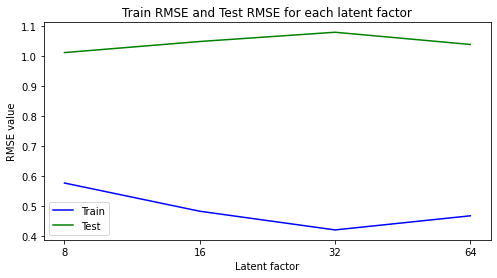

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.plot([str(lf) for lf in latent_factors],rmse_train_list, 'b', label='Train')
plt.plot([str(lf) for lf in latent_factors],rmse_test_list, 'g', label='Test')
plt.xlabel('Latent factor')
plt.ylabel('RMSE value')
plt.title('Train RMSE and Test RMSE for each latent factor')
plt.legend()

plt.savefig('Task5_Tuning.png') 

plt.show()


## Evaluating Other Models

When evaluating models, it's important to compare to some reasonable baselines. 

Fortunately, Spotlight's `rmse_score()` method can be used to evaluate any Python object that adheres to the specification of the `predict()` function. For instance, we can make a baseline "static" scoring model, which returns the same scores for each user. This set of scores is passed as numpy array in the constructor.


In [38]:
class StaticModel:
  
  def __init__(self, staticscores):
    self.numitems = len(staticscores)
    self.staticscores = staticscores
  
  #uids are the user(s) we are requesting recommendations for;
  #returns an array of scores, one for each item
  #the array is duplicated for each user requested
  def predict(self, uids, iids=None):
    #this model returns all zeros, regardless of userid
    
    #we respond to one or more uids
    uids = [uids] if isinstance(uids, int) else uids

    #if iids is specificed, we filter predicts for those userids
    iids = np.arange(self.numitems) if iids is None else iids
    return [self.staticscores[iids] for u in uids]

For instance, we can make a static baseline that just returns 0 for every item, regardless of the user.

In [39]:
mydummymodel = StaticModel(np.zeros(num_items))

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [0.0, 0.0]
Asking for one item: [0.0]
Asking for two items: [array([0., 0.])]
RMSE of our dummy model: 3.642758


## 6. Popularity-based Recommenders

**Using ratings_df**, create three new instances of StaticModel as baselines:

(a). the number of ratings for each item - you must linearly normalise this to be in the range 0-5.

(b). the number of 5 scores received by an item - you must linearly normalise this to be in the range 0-5.

(c). the average rating value for each item (no need to normalise - scores are already 0-5)

Evaluate your baseline models in terms of RMSE, as well as providing their scores for particular iids, as requested in the quiz.

In [40]:
## solution here

# (a). the number of ratings for each item - linearly normalise this to be in the range 0-5.
avg_no_rating = ratings_df.groupby(['movieId']).count() # count rating

mid_array = ratings_df['movieId'].unique()
no_rating_array = np.zeros_like(mid_array)

for index,mid in enumerate(mid_array):  
    no_rating_array[iid_map[mid]] = avg_no_rating.loc[mid]['userId']

no_rating_array = ( no_rating_array  / no_rating_array.max() ) * 5 # normalize 
a_dummymodel = StaticModel(no_rating_array)
print("RMSE of our dummy mode[l: %f" % rmse_score(a_dummymodel, test))

RMSE of our dummy mode[l: 2.887788


In [42]:
a_dummymodel.predict(0,0)

[3.2674772036474167]

In [43]:
# (b). the number of 5 scores received by an item - you must linearly normalise this to be in the range 0-5.
five_rating = ratings_df[ratings_df['rating'] == 5.0].groupby(['movieId']).count() # count 5 stars rating

mid_array = ratings_df['movieId'].unique()
no_five_array = np.zeros_like(mid_array)
    
for index,mid in enumerate(mid_array):
    if mid in five_rating.index:
        no_five_array[iid_map[mid]] = five_rating.loc[mid]['userId']

no_five_array = ( no_five_array / no_five_array.max() ) * 5 # normalize 
b_dummymodel = StaticModel(no_five_array)
print("RMSE of our dummy model: %f" % rmse_score(b_dummymodel, test))

RMSE of our dummy model: 3.308017


In [44]:
b_dummymodel.predict(0,0)

[1.5359477124183007]

In [45]:
# (c). the average rating value for each item (no need to normalise - scores are already 0-5)
item_avg_rating = ratings_df.groupby(['movieId']).mean()

mid_array = ratings_df['movieId'].unique()
avg_rating_array = np.zeros_like(mid_array)
    
for index,mid in enumerate(mid_array):
    avg_rating_array[iid_map[mid]] = item_avg_rating.loc[mid]['rating']
    
c_dummymodel = StaticModel(avg_rating_array)    
print("RMSE of our dummy model: %f" % rmse_score(c_dummymodel, test))

RMSE of our dummy model: 0.881075


In [46]:
c_dummymodel.predict(0,0)

[3.9209302325581397]

# Implicit Recommendation

This part uses a music dataset from [Last.fm](https://www.last.fm/) -- a Spotify-like music streaming service -- that was obtained by a researcher at Pompeu Fabra University (Barcelona, Spain). The relevant citation is:

```
  @book{Celma:Springer2010,
      	author = {Celma, O.},
      	title = {{Music Recommendation and Discovery in the Long Tail}},
       	publisher = {Springer},
       	year = {2010}
      }
 ```

You can have more information about the dataset at [this link](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html).

## Dataset preparation

This dataset is 600MB copmressed, and 2.4GB uncompressed. It takes 30 seconds to download on Colab. 

In [47]:
!rm -rf lastfm-dataset-1K.tar.gz
!curl -o "lastfm-dataset-1K.tar.gz" "http://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-dataset-1K.tar.gz"
#backup location
#!curl -o "lastfm-dataset-1K.tar.gz" http://macavaney.us/misc/lastfm-dataset-1K.tar.gz
!tar -zxvf lastfm-dataset-1K.tar.gz
!ls -lh lastfm-dataset-1K/

'rm' is not recognized as an internal or external command,
operable program or batch file.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  641M    0  3849    0     0   9457      0 19:45:36 --:--:-- 19:45:36  9433
  0  641M    0 1553k    0     0  1149k      0  0:09:31  0:00:01  0:09:30 1148k
  0  641M    0 6477k    0     0  2753k      0  0:03:58  0:00:02  0:03:56 2751k
  1  641M    1 10.2M    0     0  3114k      0  0:03:30  0:00:03  0:03:27 3113k
  2  641M    2 13.4M    0     0  3150k      0  0:03:28  0:00:04  0:03:24 3149k
  2  641M    2 17.4M    0     0  3335k      0  0:03:16  0:00:05  0:03:11 3609k
  3  641M    3 21.0M    0     0  3399k      0  0:03:13  0:00:06  0:03:07 4008k
  3  641M    3 24.6M    0     0  3425k      0  0:03:11  0:00:07  0:03:04 3743k
  4  641M    4 27.7M    0     0  3404k 

x lastfm-dataset-1K/
x lastfm-dataset-1K/userid-profile.tsv
x lastfm-dataset-1K/README.txt
x lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
listens_df = pd.read_csv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv",  names=['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], header=None, sep='\t')

#Some tracks dont seem to have artists or track names, so lets drop them for simplicity.
listens_df = listens_df[listens_df.artist.notnull()]
listens_df = listens_df[listens_df.trackname.notnull()]

#the dataframe is VERY big (19M interactions), so lets just work with a small sample of it (this will mean that effectiveness will be lower, but learning will be MUCH faster).
listens_df = listens_df.sample(n=200000, random_state=np.random.RandomState(SEED))


Let's look at the dataset. Note that the we don't have any explicit ratings by the users. We just know what they interacted with (and when). 

In [49]:
listens_df.head()

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


## An implicit recommendation approach

We can construct [Interaction](https://maciejkula.github.io/spotlight/interactions.html) objects for Spotlight in the same way as before. The only difference is that this time we do not record the user's ratings.


In [50]:
from collections import defaultdict
from itertools import count

#we cant trust the musicbrainz ids to exist, so lets build items ids based on artist & trackname attributes
LFMiid_map = defaultdict(count().__next__)
LFMiids = np.array([LFMiid_map[artist+"/"+trackname] for artist,trackname in listens_df[["artist","trackname"]].values ], dtype=np.int32)

LFMuid_map = defaultdict(count().__next__)
LFMuids = np.array([LFMuid_map[uid] for uid in listens_df["user"].values ], dtype=np.int32)
#freeze uid_map and iid_map so no more mapping are created
LFMuid_map.default_factory = None
LFMiid_map.default_factory = None

LFMuid_rev_map = {v: k for k, v in LFMuid_map.items()}
LFMiid_rev_map = {v: k for k, v in LFMiid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#NB: we will set num_users and num_items here
imp_dataset = Interactions(user_ids=LFMuids, item_ids=LFMiids, num_users=len(LFMuid_map), num_items=len(LFMiid_map))
#we could add the timestamps here if we were doing sequence recommendation

print(imp_dataset)

<Interactions dataset (973 users x 125076 items x 200000 interactions)>


In [51]:
from spotlight.cross_validation import random_train_test_split

itrain, itest = random_train_test_split(imp_dataset, random_state=np.random.RandomState(SEED))
print(itrain)
print(itest)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


In [52]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodel.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

Epoch 0: loss 0.9663112545967102
Epoch 1: loss 0.49532520871162417
Epoch 2: loss 0.19036926214694977
Epoch 3: loss 0.11518941595554352
Epoch 4: loss 0.08347183648347854
Training took 122 seconds


Note that the scores vary in magnitude - we're not predicting a rating, we just need to have scores in order to rank the items in descending order.

In [53]:
print(imodel.predict(0))
print(len(imodel.predict(0)))

[ -4.7575655   5.2617598  -9.297517  ...  -9.027842  -11.65852
 -13.5019245]
125076


Now that we have the scores of all items for a given user, we need to identify the top-scored ones, i.e. those that we would present to the user. 

## 7. Track Analysis

What are the top scored 10 tracks recommended for user uid 4?

In [54]:
def tracksForUser(uid : str, k : int = 4):

    all_item_score = imodel.predict(uid) # Get items score for input user
    sort_score = np.sort(all_item_score)[::-1] # Sort score highest to low
    top_score = list()
    position_score = list()    
    
    for i in range(k):
        position_score.append(np.argwhere(all_item_score==sort_score[i])) # Get position of item for each top k score 
        top_score.append(all_item_score[np.argwhere(all_item_score==sort_score[i])]) # Get top k score from position

    position_score_array = np.asarray(position_score).reshape(-1,1)

    recommend_list = list()
    
    for pos in position_score_array:
        recommend_list.append(LFMiid_rev_map.get(pos[0])) # Find artist and track from top k score

    top_score_array = np.asarray(top_score).reshape(-1,1)
    recommend_array = np.asarray(recommend_list).reshape(-1,1)
    
    return [top_score_array, recommend_array]

uid = 4
k = 10
top_score, top_rec = tracksForUser(uid=uid, k=k)

print("Top " +  str(k) + " tracks recommend for user uid" + str(uid) + " (" + LFMuid_rev_map.get(uid) +")")

for i in range(len(top_score)):
    print(str(i+1) + "." + str(top_rec[i]) + " score" + str(top_score[i]) + "")

Top 10 tracks recommend for user uid4 (user_000137)
1.['Evanescence/Sweet Sacrifice'] score[13.124208]
2.['Mgmt/Kids'] score[12.6752615]
3.['The Killers/Bones'] score[12.663373]
4.['Nelly Furtado/Say It Right'] score[12.464312]
5.['Kings Of Leon/Use Somebody'] score[12.43695]
6.['Amy Winehouse/Back To Black'] score[12.17378]
7.['Red Hot Chili Peppers/The Zephyr Song'] score[11.530693]
8.['Radiohead/Fake Plastic Trees'] score[10.85973]
9.['Incubus/Drive'] score[10.710889]
10.['Him/The Funeral Of Hearts'] score[10.703493]


## 8. Artist Analysis

Look at the artists actually listened to by uid 4, and compare/contrast with the predictions of the recommender. It's useful to examine how many times each artist was listened to.

In [67]:
uid = 4
user = LFMuid_rev_map.get(uid)

listen_artist = listens_df[listens_df["user"] == user][['artist','trackname']].groupby('artist').count()
listen_artist.rename(columns = ({'trackname' : 'count'}),inplace=True)
sort_listen_artist = listen_artist[listen_artist['count'] >= 1].sort_values(by=['count'], ascending=False)
sort_listen_artist

,count
artist,
Soda Stereo,39
Gustavo Cerati,36
Radiohead,31
Lucybell,27
Silvio Rodríguez,16
...,...
Inti Illimani\Inti+Quila,1
Interpol,1
Incubus,1


I observed that uid 4 listened frequently to "Radiohead" (rank 3), while a Radiohead song was among the top 10 ranked songs in our predicted model.

## Evaluating an implicit recommender




We can examine the MRR of the implicit model we have learned. We pass it the test set (which contains knowledge of what the user *actually* clicked), as our ground truth. 

In the second variant, we also pass the training data. Give a look at the  implementation of [mrr_score()](https://github.com/cmacdonald/spotlight/blob/master/spotlight/evaluation.py#L8) to understand what it is doing, and why.

In [56]:
from spotlight.evaluation import mrr_score

#evaluate on this dataset takes approx 1 minute
#!date
print(mrr_score(imodel, itest).mean())
#!date
print(mrr_score(imodel, itest,  train=itrain).mean())
#!date


0.03720125940064275
0.008104536778740273


How to interpret an MRR score - we know it has a range [0,1] with 1 being best. 1 means, on average across all users, we make a relevant prediction at rank 1; 0.5 means, on average, at rank 2. This is a very rough rule-of-thumb - MRR isn't a linear measure, so  a few poor predictions affect the average more than a few good ones.


## Task 9. Listens and Recommendations

*   Pick the user with the lowest uid that has RR=1 (you should not specify `train=` when making this choice). How many listens (ie. how many times they have listened to any song) did they have in the training dataset?
*   Similarly, pick the user with the lowest uid that had the lowest RR. How many listens did they have in the training dataset?



In [57]:
m_score = mrr_score(imodel, itest)

In [58]:
user_rr_pos = np.argwhere(m_score==1) # Find position of uid with RR=1
user_rr_pos = user_rr_pos.reshape(1,-1)[0]

high_rr_uid = LFMuid_rev_map.get(user_rr_pos[0]) # Select lowest uid

high_current_listen = listens_df[listens_df["user"] == high_rr_uid]['trackname'].count()
print("Total times user uid" + str(user_rr_pos[0]) + " (" + high_rr_uid +") (RR=" + str(m_score[user_rr_pos[0]]) + ") listen to a song: " + str(high_current_listen) + " times")

user_low_rr = np.argwhere(m_score==0)
user_low_rr = user_low_rr.reshape(1,-1)[0]

low_rr_uid = LFMuid_rev_map.get(user_low_rr[0]) # Select lowest uid

low_current_listen = listens_df[listens_df["user"] == low_rr_uid]['trackname'].count()
print("Total times user uid" + str(user_low_rr[0]) + " (" + low_rr_uid +") (RR=" + str(m_score[user_low_rr[0]]) + ") listen to a song: " + str(low_current_listen) + " times")

Total times user uid31 (user_000833) (RR=1.0) listen to a song: 950 times
Total times user uid1 (user_000093) (RR=0.0) listen to a song: 442 times


In [61]:
uid_no_listen = np.zeros_like(m_score)
for usrid in range(len(np.unique(LFMuids))):
    uid_no_listen[usrid] = listens_df[listens_df["user"] == LFMuid_rev_map.get(usrid)]['trackname'].count()
    uid_no_listen

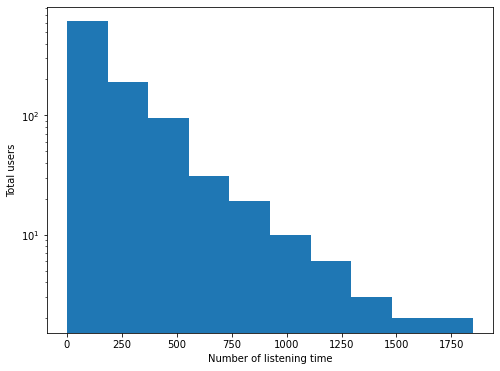

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bin = plt.hist(uid_no_listen, bins=10, log=True)

#plt.ylim(0,10**3)
plt.xlabel('Number of listening time')
plt.ylabel('Total users')


plt.savefig('Number_of_listen_uid.png')
plt.show()

In [63]:
bin

(array([613., 192.,  95.,  31.,  19.,  10.,   6.,   3.,   2.,   2.]),
 array([1.0000e+00, 1.8570e+02, 3.7040e+02, 5.5510e+02, 7.3980e+02,
        9.2450e+02, 1.1092e+03, 1.2939e+03, 1.4786e+03, 1.6633e+03,
        1.8480e+03]),
 <BarContainer object of 10 artists>)

Many users have very few listens. Lets set 20 listens as a threshold.

Lets define users with < 20 listens as cold-start users.
How many cold-start users are there?
What is the MRR for ONLY these users, versus "normal" with 20 or more listens.


In [74]:
listen20 = list()

for i in range(len(LFMuid_rev_map)):
    listen_co = listens_df[listens_df["user"] == LFMuid_rev_map.get(i)]['trackname'].count()
    if (listen_co < 20):
        listen20.append(i)
        
listen20_array = np.asarray(listen20)
print('How many cold-start users?:', len(listen20))
print(m_score[listen20_array].mean())

How many cold-start users?: 137
0.002867570385818561


In [76]:
listen = list()

for i in range(len(LFMuid_rev_map)):
    listen_co = listens_df[listens_df["user"] == LFMuid_rev_map.get(i)]['trackname'].count()
    if (listen_co >= 20):
        listen.append(i)
print('How many user listen 20 or more?:', len(listen))
print(m_score[listen].mean())

How many user listen 20 or more?: 836
0.04282771322245006


## 10 - BPR

Finally, let's compare the *pointwise* implicit factorisation model with *BPR*. BPR is a very key recommendation model in the literature, which is widely used today as a baseline in many research papers.

In [64]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel_BPR = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    loss='bpr',
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodel_BPR.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

print("MRR Score of model with BPR:", mrr_score(imodel_BPR, itest).mean())

Epoch 0: loss 0.4740972496986389
Epoch 1: loss 0.1468369757294655
Epoch 2: loss 0.024808171512186526
Epoch 3: loss 0.014375458194687963
Epoch 4: loss 0.011113861539959908
Training took 122 seconds
MRR Score of model with BPR: 0.05814735966328977


In [78]:
print("MRR Score of normal model:", mrr_score(imodel, itest).mean())

MRR Score of normal model: 0.03720125940064275
